> **Binary** **classification** **model** : AntsBees  

> **Coding** **Stye**: TypeB

> **Section**: Training Class


In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path


In [ ]:
torch.cuda.synchronize()
print(torch.cuda.memory_allocated())

0


In [ ]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data'

In [ ]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/AntsBees')

###Deviceの設定

In [ ]:
# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#(1) DataSet の作成

### train_list, val_list の作成

In [ ]:
import glob
import pprint

def make_path_list(phase='train'):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    tt= phase +'/**/*.jpg'
    target_path = os.path.join(root_dir,tt)
    # ファイルパスを格納するリスト
    path_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# ファイルパスのリストを生成
train_list = make_path_list(phase='train')
val_list = make_path_list(phase='val')





In [ ]:
print(train_list[4])
print(val_list[4])

/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg
/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/val/ants/1124525276_816a07c17f.jpg


In [ ]:
p=Path(train_list[5])
print(p.parts[-2])

p2=Path(val_list[-4])
print(p2.parts[-2])

ants
bees


#（２）DataSetの作成

In [ ]:
from util.ImageTransform import ImageTransform
from dsets.dsets import make_path_list
from dsets.dsets import MakeBalancedDataset
from torch.utils.data import DataLoader


train_list = make_path_list(phase='train',root_dir=root_dir)
val_list = make_path_list(phase='val',root_dir=root_dir)

file_list={'train':train_list,'val':val_list}


SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用


# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD


file_list={'train':train_list,'val':val_list}


# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeBalancedDataset(
    file_list=file_list, # 訓練データのファイルパス
    ratio_int=True,
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train',
    records=300)
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeBalancedDataset(
    file_list=file_list, # 検証データのファイルパス
    ratio_int=True,
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val',
    records=200)


In [ ]:
print(len(train_list))
print(len(val_list))

242
153


#(2) DataLoader の作成

In [ ]:
'''
6. データローダーの生成
'''
from torch.utils.data import DataLoader

# 訓練用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 検証用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



#(4) モデルの作成

###初期学習と継続学習とを区別する

In [ ]:
from models.networks import network_vgg16



In [ ]:
'''
7. 学習済みのVGG16モデルをロード
'''
from torchvision import models
import torch.nn as nn

class Model():
  
  def __init__(self,save_dir,isTrain,use_cuda,continue_train,which_epoch=0):
    
    self.save_dir = save_dir
    self.isTrain = isTrain
    self.continue_train = continue_train
    self.use_cuda = use_cuda
    self.which_epoch = which_epoch

    if self.isTrain:
      self.model = network_vgg16()
      print('train')
      self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001,momentum=0.99)

      if not self.isTrain or self.continue_train:
        self.load_network(self.model,self.which_epoch)
        print('continued train')

  def load_network(self,network,which_epoch):
      save_filename = 'net_%s.pth' % (which_epoch)
      save_path = os.path.join(self.save_dir, save_filename)
      network.load_state_dict(torch.load(save_path))
      print('load network:',save_path)

  def train(self):
    self.model.train()

  def eval(self):
    self.model.eval()




In [ ]:
import os
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks/AntsBees


In [ ]:
epoch_start=int(18)+1
epoch_end=epoch_start+4
epoch_end=epoch_start+4

for epoch_ndx in range(epoch_start,epoch_end):
  print(epoch_ndx)

19
20
21
22


In [ ]:
import pickle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

import torch.optim as optim

METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE = 3


# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザー
#optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.99)

metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}

class Training:
  def __init__(self,continue_train=True,which_epoch=0,how_much_epoch=4,save_freq=4):
    #self.model=model(self.save_dir,self.isTrain,self.use_cuda,self.continue_train,self.which_epoch)
    #self.optimizer=optim.SGD(params=self.model.parameters(), lr=0.001, momentum=0.99)
    self.num_epochs=10
    self.batch_size=10
    self.use_cuda = True
    self.continue_train = continue_train
    self.isTrain = True
    #self.train_dl = train_dl
    #self.val_dl = val_dl
    self.device = torch.device("cuda" if self.use_cuda else "cpu")
    #self.augmentation_dict = opt.augmentation_dict
    self.save_dir = 'network'
    self.log_dir = 'logmetrics'
    self.how_much_epoch=how_much_epoch
    self.which_epoch=which_epoch
    self.save_freq = 4
    self.model=Model(self.save_dir,self.isTrain,self.use_cuda,self.continue_train,self.which_epoch)
    self.metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}

  def main(self):
    t_epoch_start = time.time()
    if self.continue_train:
      epoch_start=int(self.which_epoch)+1
      epoch_end=epoch_start+self.how_much_epoch
    else:
      epoch_start=1
      epoch_end=epoch_start + self.how_much_epoch

    #metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}

    for epoch_ndx in range(epoch_start,epoch_end):

      # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
      print('----epoch:{}----'.format(epoch_ndx))
      trnMetrics_t = self.doTraining(epoch_ndx, train_dl)

      self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)
      print('doTraining_end')

      valMetrics_t = self.doValidation(epoch_ndx, val_dl)
      self.logMetrics(epoch_ndx, 'val', valMetrics_t)
      print('doValidation_end')

      if epoch_ndx % self.save_freq == 0:
        print('saving the model at the end of epoch %d' % (epoch_ndx))
        self.save_network(self.model.model,epoch_ndx)
        print('saving the logMetrics at the end of epoch %d' % (epoch_ndx))
        self.save_file(self.metrics_dict,epoch_ndx)
    t_epoch_finish = time.time()

    print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))


  def save_network(self, network, epoch_ndx, cpu=False):
      save_filename = 'net_%s.pth' % (epoch_ndx)
      save_path = os.path.join(self.save_dir, save_filename)
      torch.save(network.cpu().state_dict(), save_path)
      if not cpu and torch.cuda.is_available():
          network.cuda()

  def save_file(self,logMetrics,epoch_ndx):
      save_filename = 'logMetrics_%s.pickle' % (epoch_ndx)
      save_path = os.path.join(self.log_dir, save_filename)
      with open(save_path, mode='wb') as f:
          pickle.dump(logMetrics,f)


  def doTraining(self, epoch_ndx, train_dl):

    self.model.train()
    trnMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(train_dl.dataset),
            device=self.device,
        )

    for batch_ndx, batch_tup in enumerate(tqdm(train_dl)):
      self.model.optimizer.zero_grad()

      loss_var = self.computeBatchLoss(
        batch_ndx,
        batch_tup,
        train_dl.batch_size,
        trnMetrics_g,)
    
      loss_var.backward()
      self.model.optimizer.step()

    return trnMetrics_g.to('cpu')

  def doValidation(self, epoch_ndx, val_dl):
      with torch.no_grad():
          self.model.eval()
          valMetrics_g = torch.zeros(
              METRICS_SIZE,
              len(val_dl.dataset),
              device=self.device,
            )

          for batch_ndx, batch_tup in enumerate(tqdm(val_dl)):
              self.computeBatchLoss(
                batch_ndx,
                batch_tup,
                val_dl.batch_size,
                valMetrics_g,
              )

      return valMetrics_g.to('cpu')


  def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):

      input_t, label_t = batch_tup
      input_g = input_t.to(device)
      label_g = label_t.to(device)
      #model= self.model.to(device)

      outputs  = self.model.model(input_g)

      softmax = nn.Softmax(dim=1)
      prob_g= softmax(outputs)

      loss_func = nn.CrossEntropyLoss(reduction='none')
      loss_g = loss_func(outputs,label_g)

      start_ndx = batch_ndx * batch_size
      end_ndx = start_ndx + label_g.size()[0]

      metrics_g[0, start_ndx:end_ndx] = label_g
      metrics_g[1, start_ndx:end_ndx] = prob_g[:,1].detach()
      metrics_g[2, start_ndx:end_ndx] = loss_g.detach()
      
      return loss_g.mean()

  #epochごとに算出する
  def logMetrics(self,epoch_ndx,phase,metrics_t):

      negLabel_mask = metrics_t[0] <= 0.5
      negPred_mask = metrics_t[1] <= 0.5

      posLabel_mask = ~negLabel_mask
      posPred_mask = ~negPred_mask

      neg_count = int(negLabel_mask.sum())
      pos_count = int(posLabel_mask.sum())

      trueNeg_count = neg_correct = int((negLabel_mask & negPred_mask).sum())
      truePos_count = pos_correct = int((posLabel_mask & posPred_mask).sum())

      falsePos_count = neg_count - neg_correct
      falseNeg_count = pos_count - pos_correct

      print('accuracy_all:{:.3f}'.format((pos_correct + neg_correct) / metrics_t.shape[1] * 100))
      print('accuracy_neg:{:.3f}'.format((neg_correct) / neg_count * 100))
      print('accuracy_pos:{:.3f}'.format((pos_correct) / pos_count * 100))

      self.metrics_dict['phase'].append(phase)
      self.metrics_dict['epoch_ndx'].append(epoch_ndx)
      self.metrics_dict['loss/all'].append(metrics_t[METRICS_LOSS_NDX].mean().item())
      self.metrics_dict['loss/neg'].append(metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean().item())
      self.metrics_dict['loss/pos'].append(metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean().item())

      self.metrics_dict['correct/all'].append((pos_correct + neg_correct) / metrics_t.shape[1] * 100)
      self.metrics_dict['correct/neg'].append((neg_correct) / neg_count * 100)
      self.metrics_dict['correct/pos'].append((pos_correct) / pos_count * 100)

      self.metrics_dict['pr/precision'].append(truePos_count / np.float32(truePos_count + falsePos_count))
      self.metrics_dict['pr/recall'].append(truePos_count / np.float32(truePos_count + falseNeg_count))

      precision = truePos_count / np.float32(truePos_count + falsePos_count)
      recall = truePos_count / np.float32(truePos_count + falseNeg_count)

      self.metrics_dict['pr/f1_score'].append(2 * (precision * recall) / (precision + recall)) 

      



#初回学習

In [ ]:
Training(continue_train=False,how_much_epoch=4,save_freq=4).main()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

classifier.6.weight
classifier.6.bias
train
----epoch:1----


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


accuracy_all:79.752
accuracy_neg:77.869
accuracy_pos:81.667
doTraining_end


100%|██████████| 16/16 [00:50<00:00,  3.18s/it]


accuracy_all:96.732
accuracy_neg:95.714
accuracy_pos:97.590
doValidation_end
----epoch:2----


100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


accuracy_all:93.388
accuracy_neg:90.984
accuracy_pos:95.833
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.12it/s]


accuracy_all:96.732
accuracy_neg:97.143
accuracy_pos:96.386
doValidation_end
----epoch:3----


100%|██████████| 25/25 [00:02<00:00, 10.87it/s]


accuracy_all:94.628
accuracy_neg:94.262
accuracy_pos:95.000
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.78it/s]


accuracy_all:95.425
accuracy_neg:95.714
accuracy_pos:95.181
doValidation_end
----epoch:4----


100%|██████████| 25/25 [00:02<00:00, 11.56it/s]


accuracy_all:97.934
accuracy_neg:98.361
accuracy_pos:97.500
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.80it/s]


accuracy_all:96.078
accuracy_neg:97.143
accuracy_pos:95.181
doValidation_end
saving the model at the end of epoch 4
saving the logMetrics at the end of epoch 4
timer:  104.4442 sec.


In [ ]:
with open('logmetrics/logMetrics_4.pickle','rb') as f:
  df=pickle.load(f)
print(df)

{'epoch_ndx': [1, 1, 2, 2, 3, 3, 4, 4], 'phase': ['trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val'], 'loss/all': [0.40094202756881714, 0.13093912601470947, 0.28687602281570435, 0.24209365248680115, 0.24475722014904022, 0.32391059398651123, 0.05987364053726196, 0.40586715936660767], 'loss/neg': [0.38867682218551636, 0.13716267049312592, 0.43134453892707825, 0.1936231106519699, 0.17015300691127777, 0.3132381737232208, 0.0359080545604229, 0.35760605335235596], 'loss/pos': [0.4134116768836975, 0.12569034099578857, 0.13999976217746735, 0.28297239542007446, 0.3206048905849457, 0.3329114019870758, 0.08423865586519241, 0.4465693235397339], 'correct/all': [79.75206611570248, 96.73202614379085, 93.38842975206612, 96.73202614379085, 94.62809917355372, 95.42483660130719, 97.93388429752066, 96.07843137254902], 'correct/neg': [77.8688524590164, 95.71428571428572, 90.98360655737704, 97.14285714285714, 94.26229508196722, 95.71428571428572, 98.36065573770492, 97.14285714285714], 'correct/pos': [8

#継続学習

### epoch=4のモデルを読み込んで、epoch=4回分、学習を継続する

In [ ]:
Training(continue_train=True,which_epoch=4,how_much_epoch=4,save_freq=4).main()

classifier.6.weight
classifier.6.bias
train
load network: network/net_4.pth
continued train
----epoch:5----


100%|██████████| 25/25 [00:02<00:00,  9.08it/s]


accuracy_all:97.531
accuracy_neg:98.361
accuracy_pos:96.694
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.70it/s]


accuracy_all:97.386
accuracy_neg:97.143
accuracy_pos:97.590
doValidation_end
----epoch:6----


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


accuracy_all:96.296
accuracy_neg:95.082
accuracy_pos:97.521
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


accuracy_all:96.078
accuracy_neg:97.143
accuracy_pos:95.181
doValidation_end
----epoch:7----


100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


accuracy_all:96.708
accuracy_neg:95.902
accuracy_pos:97.521
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


accuracy_all:95.425
accuracy_neg:97.143
accuracy_pos:93.976
doValidation_end
----epoch:8----


100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


accuracy_all:97.119
accuracy_neg:98.361
accuracy_pos:95.868
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.68it/s]


accuracy_all:95.425
accuracy_neg:97.143
accuracy_pos:93.976
doValidation_end
saving the model at the end of epoch 8
saving the logMetrics at the end of epoch 8
timer:  21.6169 sec.


In [ ]:
with open('logmetrics/logMetrics_8.pickle','rb') as f:
  df=pickle.load(f)
print(df)

{'epoch_ndx': [5, 5, 6, 6, 7, 7, 8, 8], 'phase': ['trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val'], 'loss/all': [0.1609499156475067, 0.20080764591693878, 0.1757982224225998, 0.2455892413854599, 0.20594224333763123, 0.27826085686683655, 0.22360025346279144, 0.3226856291294098], 'loss/neg': [0.05199730023741722, 0.26429373025894165, 0.2661421000957489, 0.1592920571565628, 0.18748317658901215, 0.11170906573534012, 0.02784634754061699, 0.03173687681555748], 'loss/pos': [0.27080294489860535, 0.14726516604423523, 0.08470767736434937, 0.3183700442314148, 0.22455385327339172, 0.4187261760234833, 0.42097198963165283, 0.5680640935897827], 'correct/all': [97.53086419753086, 97.38562091503267, 96.29629629629629, 96.07843137254902, 96.70781893004116, 95.42483660130719, 97.11934156378601, 95.42483660130719], 'correct/neg': [98.36065573770492, 97.14285714285714, 95.08196721311475, 97.14285714285714, 95.90163934426229, 97.14285714285714, 98.36065573770492, 97.14285714285714], 'correct/pos': [96

### epoch=8のモデルを読み込んで、epoch=4回分、学習を継続する

In [ ]:
Training(continue_train=True,which_epoch=8,how_much_epoch=4,save_freq=4).main()

classifier.6.weight
classifier.6.bias
train
load network: network/net_8.pth
continued train
----epoch:9----


100%|██████████| 25/25 [00:02<00:00,  8.94it/s]


accuracy_all:93.827
accuracy_neg:94.262
accuracy_pos:93.388
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  8.00it/s]


accuracy_all:96.732
accuracy_neg:97.143
accuracy_pos:96.386
doValidation_end
----epoch:10----


100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


accuracy_all:95.885
accuracy_neg:94.262
accuracy_pos:97.521
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.81it/s]


accuracy_all:96.078
accuracy_neg:98.571
accuracy_pos:93.976
doValidation_end
----epoch:11----


100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


accuracy_all:95.885
accuracy_neg:94.262
accuracy_pos:97.521
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.67it/s]


accuracy_all:95.425
accuracy_neg:97.143
accuracy_pos:93.976
doValidation_end
----epoch:12----


100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


accuracy_all:95.062
accuracy_neg:95.082
accuracy_pos:95.041
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.93it/s]


accuracy_all:94.118
accuracy_neg:91.429
accuracy_pos:96.386
doValidation_end
saving the model at the end of epoch 12
saving the logMetrics at the end of epoch 12
timer:  22.6314 sec.


In [ ]:
with open('logmetrics/logMetrics_12.pickle','rb') as f:
  df=pickle.load(f)
print(df)

{'epoch_ndx': [9, 9, 10, 10, 11, 11, 12, 12], 'phase': ['trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val'], 'loss/all': [0.36907994747161865, 0.2484544813632965, 0.1876516342163086, 0.3539607524871826, 0.3026646375656128, 0.3448130190372467, 0.19308461248874664, 0.48201218247413635], 'loss/neg': [0.37759295105934143, 0.14485757052898407, 0.15945252776145935, 0.08252274245023727, 0.3223026394844055, 0.14392654597759247, 0.13487133383750916, 0.9317216277122498], 'loss/pos': [0.36049649119377136, 0.3358253836631775, 0.21608377993106842, 0.5828843116760254, 0.2828643023967743, 0.5142353773117065, 0.2517789602279663, 0.10273918509483337], 'correct/all': [93.82716049382715, 96.73202614379085, 95.88477366255144, 96.07843137254902, 95.88477366255144, 95.42483660130719, 95.06172839506173, 94.11764705882352], 'correct/neg': [94.26229508196722, 97.14285714285714, 94.26229508196722, 98.57142857142858, 94.26229508196722, 97.14285714285714, 95.08196721311475, 91.42857142857143], 'correct/pos': 

### epoch=12のモデルを読み込んで、epoch=4回分、学習を継続する

In [ ]:
Training(continue_train=True,which_epoch=12,how_much_epoch=4,save_freq=4).main()

classifier.6.weight
classifier.6.bias
train
load network: network/net_12.pth
continued train
----epoch:13----


100%|██████████| 25/25 [00:02<00:00,  8.83it/s]


accuracy_all:94.650
accuracy_neg:92.623
accuracy_pos:96.694
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


accuracy_all:95.425
accuracy_neg:95.714
accuracy_pos:95.181
doValidation_end
----epoch:14----


100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


accuracy_all:97.531
accuracy_neg:100.000
accuracy_pos:95.041
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.79it/s]


accuracy_all:95.425
accuracy_neg:95.714
accuracy_pos:95.181
doValidation_end
----epoch:15----


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


accuracy_all:97.531
accuracy_neg:97.541
accuracy_pos:97.521
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.95it/s]


accuracy_all:95.425
accuracy_neg:94.286
accuracy_pos:96.386
doValidation_end
----epoch:16----


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


accuracy_all:96.296
accuracy_neg:94.262
accuracy_pos:98.347
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.66it/s]


accuracy_all:96.732
accuracy_neg:97.143
accuracy_pos:96.386
doValidation_end
saving the model at the end of epoch 16
saving the logMetrics at the end of epoch 16
timer:  22.4728 sec.


In [ ]:
with open('logmetrics/logMetrics_16.pickle','rb') as f:
  df=pickle.load(f)
print(df)

{'epoch_ndx': [13, 13, 14, 14, 15, 15, 16, 16], 'phase': ['trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val'], 'loss/all': [0.17611442506313324, 0.42756667733192444, 0.18896250426769257, 0.4184344410896301, 0.17619943618774414, 0.3917209506034851, 0.22786182165145874, 0.33452412486076355], 'loss/neg': [0.30494746565818787, 0.3738877475261688, 0.007854694500565529, 0.3287510871887207, 0.08537153899669647, 0.4419246017932892, 0.368407666683197, 0.1835719794034958], 'loss/pos': [0.04621664434671402, 0.4728381037712097, 0.37156710028648376, 0.49407094717025757, 0.2677779793739319, 0.3493804335594177, 0.08615443855524063, 0.4618331789970398], 'correct/all': [94.65020576131687, 95.42483660130719, 97.53086419753086, 95.42483660130719, 97.53086419753086, 95.42483660130719, 96.29629629629629, 96.73202614379085], 'correct/neg': [92.62295081967213, 95.71428571428572, 100.0, 95.71428571428572, 97.54098360655738, 94.28571428571428, 94.26229508196722, 97.14285714285714], 'correct/pos': [96.69421

### epoch=16のモデルを読み込んで、epoch=4回分、学習を継続する

In [ ]:
Training(continue_train=True,which_epoch=16,how_much_epoch=4,save_freq=4).main()

classifier.6.weight
classifier.6.bias
train
load network: network/net_16.pth
continued train
----epoch:17----


100%|██████████| 25/25 [00:02<00:00,  9.14it/s]


accuracy_all:96.296
accuracy_neg:95.902
accuracy_pos:96.694
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  8.55it/s]


accuracy_all:96.732
accuracy_neg:97.143
accuracy_pos:96.386
doValidation_end
----epoch:18----


100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


accuracy_all:97.942
accuracy_neg:99.180
accuracy_pos:96.694
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.83it/s]


accuracy_all:95.425
accuracy_neg:97.143
accuracy_pos:93.976
doValidation_end
----epoch:19----


100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


accuracy_all:96.296
accuracy_neg:95.902
accuracy_pos:96.694
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.90it/s]


accuracy_all:97.386
accuracy_neg:97.143
accuracy_pos:97.590
doValidation_end
----epoch:20----


100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


accuracy_all:95.062
accuracy_neg:95.082
accuracy_pos:95.041
doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.65it/s]


accuracy_all:97.386
accuracy_neg:97.143
accuracy_pos:97.590
doValidation_end
saving the model at the end of epoch 20
saving the logMetrics at the end of epoch 20
timer:  22.6043 sec.


#すべてのlogMetrics.pickleを読み込んでマージして、図表を作成する

In [ ]:
import glob
pickle_files=glob.glob('logmetrics/*.pickle')

In [ ]:
print(pickle_files)

['logmetrics/logMetrics_4.pickle', 'logmetrics/logMetrics_8.pickle', 'logmetrics/logMetrics_12.pickle', 'logmetrics/logMetrics_16.pickle', 'logmetrics/logMetrics_20.pickle']


In [ ]:
import pickle
import pandas as pd

metrics_list=[]
for file in pickle_files:
  with open(file,'rb') as f:
    d=pickle.load(f)
    df=pd.DataFrame(d)
    metrics_list.append(df)

print(metrics_list)
df=pd.concat(metrics_list,axis=0)

display(df)

[   epoch_ndx phase  loss/all  ...  pr/precision  pr/recall  pr/f1_score
0          1   trn  0.352068  ...      0.838983   0.818182     0.828452
1          1   val  0.150938  ...      0.962963   0.939759     0.951220
2          2   trn  0.199374  ...      0.951220   0.966942     0.959016
3          2   val  0.193100  ...      0.941860   0.975904     0.958580
4          3   trn  0.245235  ...      0.957983   0.942149     0.950000
5          3   val  0.199039  ...      0.963855   0.963855     0.963855
6          4   trn  0.237065  ...      0.929688   0.983471     0.955823
7          4   val  0.239174  ...      0.975309   0.951807     0.963415

[8 rows x 11 columns],    epoch_ndx phase  loss/all  ...  pr/precision  pr/recall  pr/f1_score
0          5   trn  0.160950  ...      0.983193   0.966942     0.975000
1          5   val  0.200808  ...      0.975904   0.975904     0.975904
2          6   trn  0.175798  ...      0.951613   0.975207     0.963265
3          6   val  0.245589  ...      

,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
0,1,trn,0.352068,0.327351,0.376989,83.127572,84.426230,81.818182,0.838983,0.818182,0.828452
1,1,val,0.150938,0.114243,0.181886,94.771242,95.714286,93.975904,0.962963,0.939759,0.951220
2,2,trn,0.199374,0.275609,0.122510,95.884774,95.081967,96.694215,0.951220,0.966942,0.959016
3,2,val,0.193100,0.340059,0.069158,95.424837,92.857143,97.590361,0.941860,0.975904,0.958580
4,3,trn,0.245235,0.209245,0.281523,95.061728,95.901639,94.214876,0.957983,0.942149,0.950000
5,3,val,0.199039,0.266242,0.142361,96.078431,95.714286,96.385542,0.963855,0.963855,0.963855
6,4,trn,0.237065,0.373028,0.099978,95.473251,92.622951,98.347107,0.929688,0.983471,0.955823
7,4,val,0.239174,0.199915,0.272284,96.078431,97.142857,95.180723,0.975309,0.951807,0.963415
0,5,trn,0.160950,0.051997,0.270803,97.530864,98.360656,96.694215,0.983193,0.966942,0.975000
1,5,val,0.200808,0.264294,0.147265,97.385621,97.142857,97.590361,0.975904,0.975904,0.975904


In [ ]:
history_train=df.loc[df['phase']=='trn']
history_val=df.loc[df['phase']=='val']
first_train=df.loc[df['epoch_ndx']==1]
print(first_train)

key1=df['epoch_ndx']==5
key2=df['phase']=='trn'
key=key1&key2
print(key)

   epoch_ndx phase  loss/all  ...  pr/precision  pr/recall  pr/f1_score
0          1   trn  0.352068  ...      0.838983   0.818182     0.828452
1          1   val  0.150938  ...      0.962963   0.939759     0.951220

[2 rows x 11 columns]
0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
0     True
1    False
2    False
3    False
4    False
5    False
6    False
7    False
0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
dtype: bool


In [ ]:
correct_all=df.loc[(df['epoch_ndx']==5)&(df['phase']=='trn'),'correct/all']
print(correct_all)

0    97.530864
Name: correct/all, dtype: float64


In [ ]:
display(history_train)
display(history_val)

,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
0,1,trn,0.352068,0.327351,0.376989,83.127572,84.426230,81.818182,0.838983,0.818182,0.828452
2,2,trn,0.199374,0.275609,0.122510,95.884774,95.081967,96.694215,0.951220,0.966942,0.959016
4,3,trn,0.245235,0.209245,0.281523,95.061728,95.901639,94.214876,0.957983,0.942149,0.950000
6,4,trn,0.237065,0.373028,0.099978,95.473251,92.622951,98.347107,0.929688,0.983471,0.955823
0,5,trn,0.160950,0.051997,0.270803,97.530864,98.360656,96.694215,0.983193,0.966942,0.975000
2,6,trn,0.175798,0.266142,0.084708,96.296296,95.081967,97.520661,0.951613,0.975207,0.963265
4,7,trn,0.205942,0.187483,0.224554,96.707819,95.901639,97.520661,0.959350,0.975207,0.967213
6,8,trn,0.223600,0.027846,0.420972,97.119342,98.360656,95.867769,0.983051,0.958678,0.970711
0,9,trn,0.369080,0.377593,0.360496,93.827160,94.262295,93.388430,0.941667,0.933884,0.937759
2,10,trn,0.187652,0.159453,0.216084,95.884774,94.262295,97.520661,0.944000,0.975207,0.959350


,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
1,1,val,0.150938,0.114243,0.181886,94.771242,95.714286,93.975904,0.962963,0.939759,0.951220
3,2,val,0.193100,0.340059,0.069158,95.424837,92.857143,97.590361,0.941860,0.975904,0.958580
5,3,val,0.199039,0.266242,0.142361,96.078431,95.714286,96.385542,0.963855,0.963855,0.963855
7,4,val,0.239174,0.199915,0.272284,96.078431,97.142857,95.180723,0.975309,0.951807,0.963415
1,5,val,0.200808,0.264294,0.147265,97.385621,97.142857,97.590361,0.975904,0.975904,0.975904
3,6,val,0.245589,0.159292,0.318370,96.078431,97.142857,95.180723,0.975309,0.951807,0.963415
5,7,val,0.278261,0.111709,0.418726,95.424837,97.142857,93.975904,0.975000,0.939759,0.957055
7,8,val,0.322686,0.031737,0.568064,95.424837,97.142857,93.975904,0.975000,0.939759,0.957055
1,9,val,0.248454,0.144858,0.335825,96.732026,97.142857,96.385542,0.975610,0.963855,0.969697
3,10,val,0.353961,0.082523,0.582884,96.078431,98.571429,93.975904,0.987342,0.939759,0.962963


In [ ]:
print(type(history_train['epoch_ndx']))

<class 'pandas.core.series.Series'>


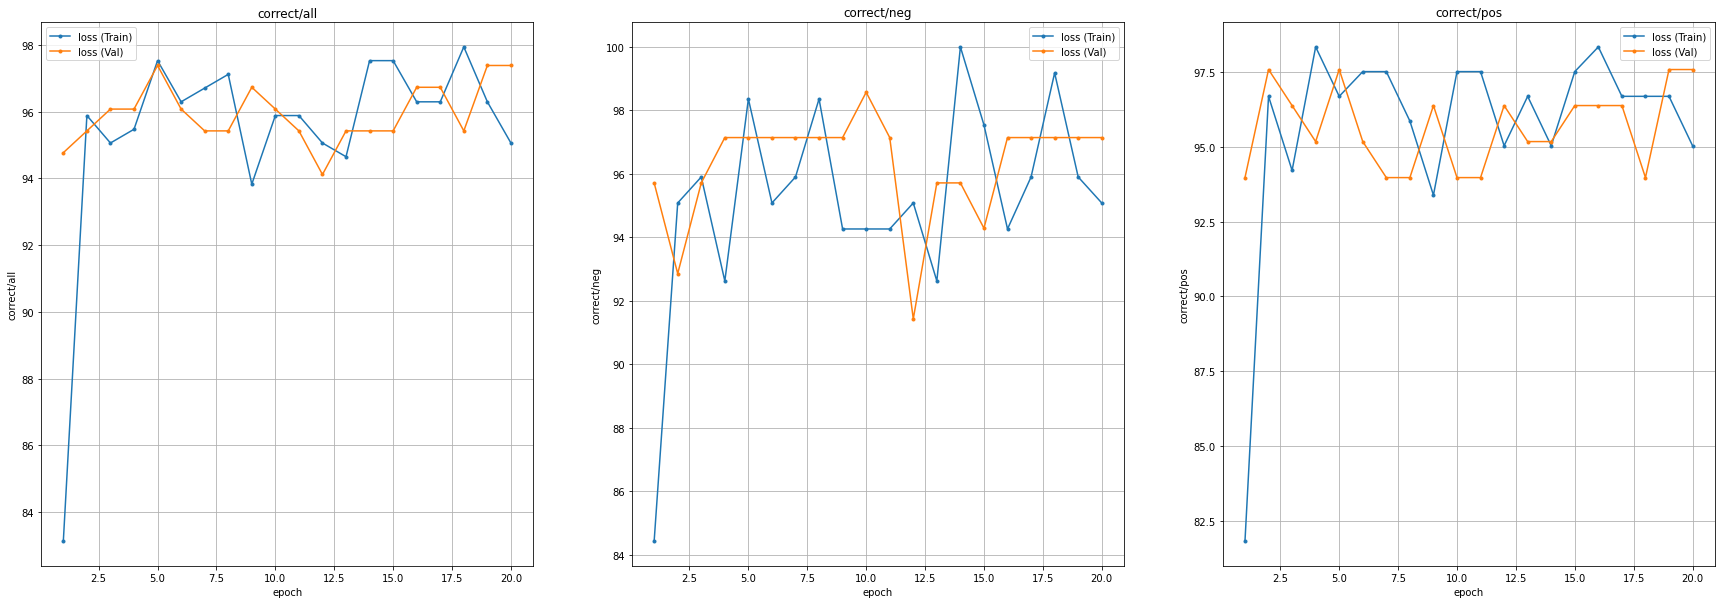

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))

# correct/all
ax1.plot(history_train['epoch_ndx'],history_train['correct/all'],
         marker='.',
         label='loss (Train)')
ax1.plot(history_val['epoch_ndx'],history_val['correct/all'],
         marker='.',
         label='loss (Val)')
ax1.legend(loc='best')
ax1.grid()
ax1.set_title('correct/all')
ax1.set_xlabel('epoch')
ax1.set_ylabel('correct/all')

# correct/all
ax2.plot(history_train['epoch_ndx'],history_train['correct/neg'],
         marker='.',
         label='loss (Train)')
ax2.plot(history_val['epoch_ndx'],history_val['correct/neg'],
         marker='.',
         label='loss (Val)')
ax2.legend(loc='best')
ax2.grid()
ax2.set_title('correct/neg')
ax2.set_xlabel('epoch')
ax2.set_ylabel('correct/neg')

# correct/all
ax3.plot(history_train['epoch_ndx'],history_train['correct/pos'],
         marker='.',
         label='loss (Train)')
ax3.plot(history_val['epoch_ndx'],history_val['correct/pos'],
         marker='.',
         label='loss (Val)')
ax3.legend(loc='best')
ax3.grid()
ax3.set_title('correct/pos')
ax3.set_xlabel('epoch')
ax3.set_ylabel('correct/pos')


plt.show()



#For Loopを用いて作図する

In [ ]:
name=df.columns.to_list()
print(name)

pop_list=[0,1]

for i in sorted(pop_list, reverse=True):
  name.pop(i)

print(name)

['epoch_ndx', 'phase', 'loss/all', 'loss/neg', 'loss/pos', 'correct/all', 'correct/neg', 'correct/pos', 'pr/precision', 'pr/recall', 'pr/f1_score']
['loss/all', 'loss/neg', 'loss/pos', 'correct/all', 'correct/neg', 'correct/pos', 'pr/precision', 'pr/recall', 'pr/f1_score']


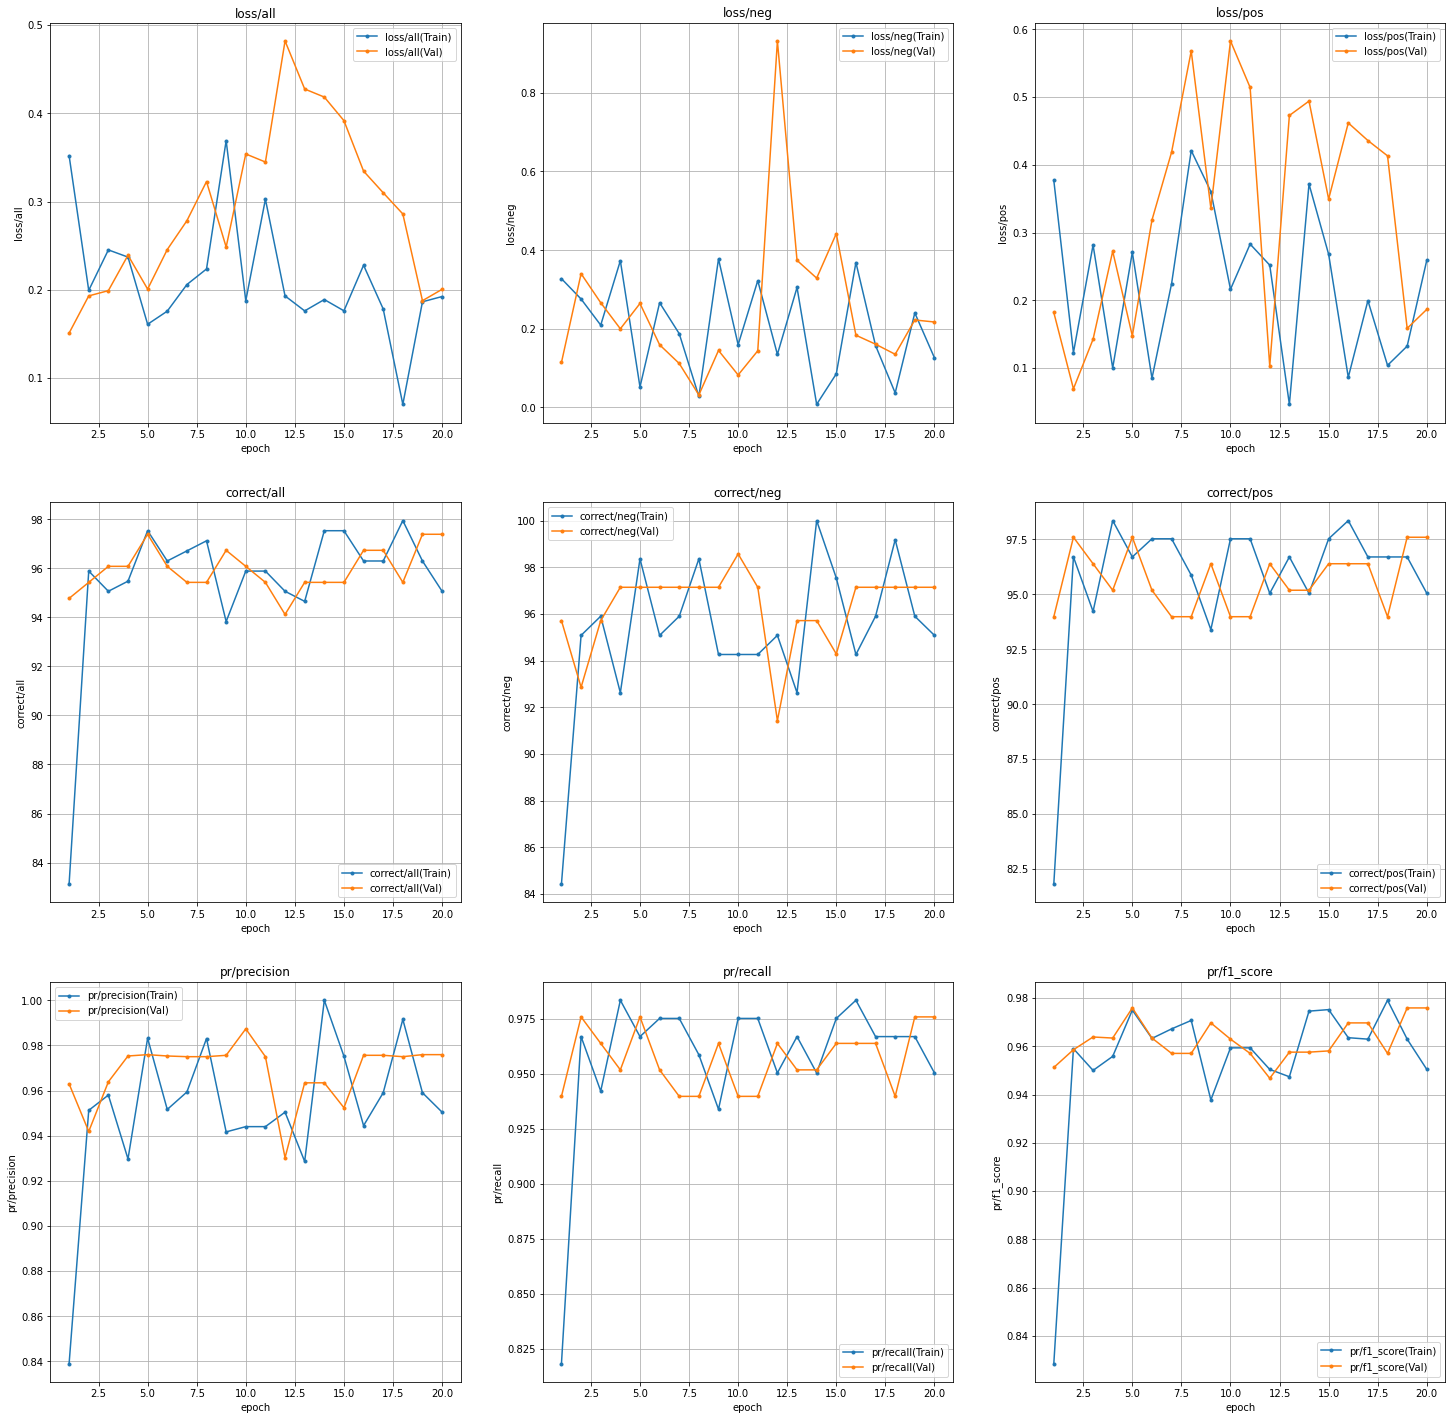

In [ ]:

fig=plt.figure(figsize=(25,25))

for i in range(9):
  ax=fig.add_subplot(3,3,i+1)
  ax.plot(history_train['epoch_ndx'],history_train[name[i]],
         marker='.',
         label=name[i] +'(Train)')
  ax.plot(history_val['epoch_ndx'],history_val[name[i]],
         marker='.',
         label=name[i] +'(Val)')
  ax.legend(loc='best')
  ax.grid()
  ax.set_title(name[i])
  ax.set_xlabel('epoch')
  ax.set_ylabel(name[i])

figname = 'result/evaluation.png'
fig.savefig(figname,bbox_inches='tight')


plt.show()

#END